# Analysis of Inflation Rate Damage Functions

#### Independent Variables : Temperature, Precipitation and Sea Level Change
#### Dependent Variable: Inflation Rate Growth Change 

In [1]:
import pandas as pd
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 99999)
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller as adf
from sklearn.metrics import r2_score
from sklearn import metrics
import math
import sklearn
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
#os.chdir(os.getcwd()[:-7] + '1. Input/2. Processed Data')
os.getcwd()

'/Users/yuqingwu/OneDrive - The University of Chicago/Winter 2022/WinterCodes/EY/2021'

### Data Transformation for dependent variables
    1. Raw Data
    2. Percentage change
    3. First difference
    4. Second difference

### Data Transformation for independent variables
    1. Raw Data
    2. First difference
    3. Second difference
    4. Raw*First difference
    5. Raw*Second difference 
    
    Based on all the data transformation we have above, we do squared and cube of them so we have 3*5 = 15 columns
    
    Again, we do lag 0.1.2 of the transformation we have. Then num of columns in the output dataframe is 15*3 = 45 columns. Lag1 implies today's GDP on yesterday's temperature. Lag2 implies today's GDP on temperature the day before yesterday.

In [2]:
'''
Data Transformation Functions:

1. These functions help create all the transformations required and store these in a dataframe for processing later
2. They are also used to transform the frequency (quarterly or annual)
3. if variable name is passed then a Data file is read from the base directory, otherwise a dataframe must be passed in df

'''

def build_dependent_df(variable, yearly=False, transform = 'Percent Change', df = None):
    if df is None:
        df = pd.read_excel(variable+".xls")
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0],format='%Y-%m-%d')
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0]).dt.to_period('Q')
        df.columns = ['Date', variable]
        df = df.set_index('Date')
        if yearly:
            df = df.resample('Y').mean()
    new_df = pd.DataFrame(index = df.index)
    org_name = df.columns[0]
    if transform == 'Raw':
        new_df[org_name] = df[org_name]
    if transform == 'Percent Change':
        name = '% chg ' + org_name
        new_df[name] = df[org_name].pct_change()
    if transform == 'Delta':
        name = r' $\Delta$' + org_name
        new_df[name] = df[org_name].diff()
    if transform == 'Delta Square':
        name = r' $\Delta^2$' + org_name
        new_df[name] = df[org_name].diff().diff()
    return new_df


def build_independent_df(variable,yearly=False, df = None):
    if df is None:
        df = pd.read_csv(variable+'.csv', skiprows = 4)
        df['Date'] = pd.to_datetime(df['Date'],format='%Y%m')
        df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M')
        df = df.drop(['Anomaly'], axis=1)
        df = df.set_index('Date')
        if yearly:
            df = df.resample('Y').mean()
        else:
            df = df.resample('Q').mean()
        
    df = df.rename(columns={"Value": variable})

    ########### Add log transformation ##############
    df[r'log'+variable] = np.log(df[variable])
    ########### Add exponential transformation ##############
    df[r'exp'+variable] = np.exp(df[variable])

    df[r' % change'+variable] = df[variable].pct_change()
    df[r'$\Delta$'+variable] = df[variable].diff()
    df[r'$\Delta^2$'+variable] = df[r'$\Delta$'+variable].diff()
    df[variable+r'*($\Delta)$'] = df[variable]*df[r'$\Delta$'+variable]
    df[variable+r'*($\Delta^2)$'] = df[variable]*df[r'$\Delta^2$'+variable]

    df_sqr = df**2
    col_names = df.columns
    for name in col_names:
        df_sqr = df_sqr.rename(columns={name:name+r'^2'})

    df_cube = df**3
    col_names = df.columns
    for name in col_names:
        df_cube = df_cube.rename(columns={name:name+r'^3'})
    df = pd.concat([df,df_sqr,df_cube], axis = 1)

    df_lag1 = df.shift()
    col_names = df.columns
    for name in col_names:
        df_lag1 = df_lag1.rename(columns={name:name+' lag1'})

    df_lag2 = df.shift(2)
    col_names = df.columns
    for name in col_names:
        df_lag2 = df_lag2.rename(columns={name:name+' lag2'})

    df = pd.concat([df,df_lag1,df_lag2], axis = 1)


    return df

In [3]:
'''
Regression Analysis Functions:

1. These functions run all possible regressions between the dependent variable and the independent variables
2. Single Regression only consider one variable in the regression
3. Multi-Regression considers a group of variables against the dependent variable in the regression

'''

def single_regression(dependent, independent, end = '2020', dummy=False):
    dependent = dependent.loc[:end]
    independent = independent.loc[:end]
    summary = pd.DataFrame(columns = ['R_squared', 'beta', 'p_value'])
    
    for dep in dependent.columns:
        lhs = dependent[dep]
        for indep in independent.columns:
            rhs = sm.add_constant(independent.loc[lhs.index, indep])
            if dummy:
                rhs['season'] = rhs.index
                rhs['season'] = rhs.index
                rhs['season'] = rhs['season'].astype(str)
                rhs['season'] = rhs['season'].str[-1:]
                dummies = pd.get_dummies(rhs['season'])
                rhs = pd.concat([rhs, dummies], axis = 1)
                rhs = rhs.drop(['season'], axis=1)
            res = sm.OLS(lhs, rhs, missing='drop').fit()
            R_squared = round(res.rsquared, 4)
            beta = round(res.params[1], 4)
            p_value = round(res.pvalues[1], 4)
            lhs_predict = res.predict(rhs)

            if len(lhs.dropna()) <= len(lhs_predict.dropna()):
                start_time = lhs.dropna().index[0]
                end_time = lhs.dropna().index[-1]
                lhs_predict = lhs_predict[str(start_time):str(end_time)] 
                mse = sklearn.metrics.mean_squared_error(lhs.dropna(), lhs_predict)
            else:
                start_time = lhs_predict.dropna().index[0]
                end_time = lhs_predict.dropna().index[-1]
                lhs_predict = lhs_predict[str(start_time):str(end_time)]  
                lhs_mse = lhs.dropna()[str(start_time):str(end_time)]
                mse = sklearn.metrics.mean_squared_error(lhs_mse, lhs_predict)
        
            summary.loc[dep + '_' + indep, 'R_squared'] = R_squared
            summary.loc[dep + '_' + indep, 'beta'] = beta
            summary.loc[dep + '_' + indep, 'p_value'] = p_value
            summary.loc[dep + '_' + indep, 'RMSE'] = math.sqrt(mse)
    
    return summary

def multi_regression(dependent, independent, end = '2020', dummy=False, indep = ['Temp', 'Temp^2','Temp'+r'*($\Delta)$']):
    dependent = dependent.loc[:end]
    independent = independent.loc[:end]
    summary = pd.DataFrame(columns = ['adj_R_squared', 'beta', 'p_value'])
    
    for dep in dependent.columns:
        lhs = dependent[dep]
        rhs = sm.add_constant(independent.loc[lhs.index, indep])
        if dummy:
            rhs['season'] = rhs.index
            rhs['season'] = rhs.index
            rhs['season'] = rhs['season'].astype(str)
            rhs['season'] = rhs['season'].str[-1:]
            dummies = pd.get_dummies(rhs['season'])
            rhs = pd.concat([rhs, dummies], axis = 1)
            rhs = rhs.drop(['season'], axis=1)
        res = sm.OLS(lhs, rhs, missing='drop').fit()
    return res

## Single Variable: Feature Engineering and Feature Selection 

In [4]:
dep_var = 'inflationRate'
dep = build_dependent_df(dep_var, yearly=True)

### Inflation Rate on Temperature

In [5]:
'''
Regress % change in inflationRate on all transformations of temperature and dispaly top 5 (one variable at a time)
'''

# Yearly Data
ind = build_independent_df('Temp', yearly=True)
summary = single_regression(dep,ind)
summary = summary.sort_values(by=['R_squared', 'p_value'], ascending=False)

display(summary.head())
columnNames = list(summary.index)
var_list = [i.split('_')[1] for i in columnNames]
print('Top variable:', var_list)

,R_squared,beta,p_value,RMSE
% chg inflationRate_Temp*($\Delta)$^3,0.1818,-0.0,0.0008,0.1451
% chg inflationRate_ % changeTemp^3,0.1671,-2546.914,0.0014,0.1464
% chg inflationRate_$\Delta$Temp^3,0.1666,-0.0162,0.0015,0.1464
% chg inflationRate_Temp*($\Delta^2)$,0.1097,-0.0007,0.0111,0.1513
% chg inflationRate_expTemp^2,0.1094,-0.0,0.0092,0.1513


Top variable: ['Temp*($\\Delta)$^3', ' % changeTemp^3', '$\\Delta$Temp^3', 'Temp*($\\Delta^2)$', 'expTemp^2', '$\\Delta^2$Temp', 'Temp*($\\Delta^2)$^3', 'expTemp^3', '$\\Delta^2$Temp^3', 'expTemp', 'Temp*($\\Delta)$', 'expTemp^3 lag1', 'expTemp^2 lag1', '$\\Delta$Temp', ' % changeTemp', 'Temp^3', 'Temp^2', 'Temp', 'logTemp^3', 'logTemp^2', 'logTemp', 'Temp*($\\Delta)$ lag1', ' % changeTemp lag1', '$\\Delta$Temp lag1', 'logTemp lag2', 'logTemp^2 lag2', 'logTemp^3 lag2', 'Temp lag2', 'Temp^2 lag2', 'Temp^3 lag2', 'Temp*($\\Delta)$^3 lag2', 'expTemp lag1', '$\\Delta$Temp^3 lag2', 'Temp*($\\Delta)$^2', ' % changeTemp^3 lag2', ' % changeTemp^2', ' % changeTemp^2 lag1', 'Temp*($\\Delta)$^2 lag1', '$\\Delta$Temp^2 lag1', '$\\Delta$Temp^2', 'Temp*($\\Delta)$ lag2', '$\\Delta$Temp lag2', ' % changeTemp lag2', 'Temp*($\\Delta^2)$^2 lag1', '$\\Delta^2$Temp^2 lag1', '$\\Delta^2$Temp^2', 'Temp*($\\Delta^2)$^2 lag2', '$\\Delta^2$Temp^2 lag2', 'Temp*($\\Delta^2)$^2', ' % changeTemp^3 lag1', 'expTemp^

In [6]:
ind

,Temp,logTemp,expTemp,% changeTemp,$\Delta$Temp,$\Delta^2$Temp,Temp*($\Delta)$,Temp*($\Delta^2)$,Temp^2,logTemp^2,...,Temp*($\Delta)$^2 lag2,Temp*($\Delta^2)$^2 lag2,Temp^3 lag2,logTemp^3 lag2,expTemp^3 lag2,% changeTemp^3 lag2,$\Delta$Temp^3 lag2,$\Delta^2$Temp^3 lag2,Temp*($\Delta)$^3 lag2,Temp*($\Delta^2)$^3 lag2
Date,,,,,,,,,,,,,,,,,,,,,
1895,50.3375,3.9188,7.2661e+21,NaN,NaN,NaN,NaN,NaN,2533.8639,15.3566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1896,51.9933,3.9511,3.8056e+22,0.0329,1.6558,NaN,86.0923,NaN,2703.3067,15.6113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1897,51.5567,3.9427,2.4591e+22,-0.0084,-0.4367,-2.0925,-22.5131,-107.8823,2658.0899,15.5447,...,NaN,NaN,127548.3744,60.1787,3.8361e+65,NaN,NaN,NaN,NaN,NaN
1898,51.4317,3.9403,2.1701e+22,-0.0024,-0.1250,0.3117,-6.4290,16.0295,2645.2163,15.5256,...,7411.8832,NaN,140553.9269,61.6821,5.5113e+67,3.5594e-05,4.5399e+00,NaN,6.3811e+05,NaN
1899,51.0092,3.9320,1.4223e+22,-0.0082,-0.4225,-0.2975,-21.5514,-15.1752,2601.9351,15.4607,...,506.8387,11638.5960,137042.2538,61.2879,1.4871e+67,-5.9239e-07,-8.3263e-02,-9.1621,-1.1410e+04,-1.2556e+06
1900,52.7733,3.9660,8.3017e+22,0.0346,1.7642,2.1867,93.1010,115.3977,2785.0247,15.7292,...,41.3315,256.9460,136047.8849,61.1748,1.0220e+67,-1.4252e-08,-1.9531e-03,0.0303,-2.6572e+02,4.1187e+03
1901,51.8742,3.9488,3.3780e+22,-0.0170,-0.8992,-2.6633,-46.6435,-138.1582,2690.9292,15.5932,...,464.4617,230.2875,132722.5404,60.7914,2.8774e+66,-5.5436e-07,-7.5419e-02,-0.0263,-1.0010e+04,-3.4947e+03
1902,51.5883,3.9433,2.5382e+22,-0.0055,-0.2858,0.6133,-14.7457,31.6408,2661.3561,15.5496,...,8667.7879,13316.6266,146975.0374,62.3821,5.7214e+68,4.1369e-05,5.4906e+00,10.4556,8.0698e+05,1.5367e+06
1903,50.6242,3.9244,9.6782e+21,-0.0187,-0.9642,-0.6783,-48.8101,-34.3401,2562.8063,15.4011,...,2175.6181,19087.6875,139589.7081,61.5747,3.8547e+67,-4.9463e-06,-7.2698e-01,-18.8919,-1.0148e+05,-2.6371e+06


In [7]:
'''
Get the correlation among variables
'''

tempdf = ind[var_list]
corrdf = dep.join(tempdf)
corrdf.corr()

,% chg inflationRate,Temp*($\Delta)$^3,% changeTemp^3,$\Delta$Temp^3,Temp*($\Delta^2)$,expTemp^2,$\Delta^2$Temp,Temp*($\Delta^2)$^3,expTemp^3,$\Delta^2$Temp^3,...,% changeTemp^2 lag2,Temp*($\Delta)$^2 lag2,$\Delta$Temp^2 lag2,Temp^3 lag1,logTemp^3 lag1,Temp lag1,logTemp^2 lag1,logTemp lag1,Temp^2 lag1,expTemp lag2
% chg inflationRate,1.0000,-0.4263,-0.4088,-0.4081,-0.3312,-0.3335,-0.3246,-0.3204,-0.3150,-0.3116,...,0.0437,0.0345,0.0310,0.0123,-0.0011,0.0015,-0.0025,-0.0038,0.0069,0.0159
Temp*($\Delta)$^3,-0.4263,1.0000,0.9970,0.9984,0.7172,0.3849,0.7151,0.8486,0.3551,0.8441,...,0.1307,0.1391,0.1452,-0.3978,-0.3884,-0.3903,-0.3875,-0.3866,-0.3940,-0.0936
% changeTemp^3,-0.4088,0.9970,1.0000,0.9965,0.7352,0.3600,0.7335,0.8391,0.3273,0.8346,...,0.1265,0.1351,0.1414,-0.4097,-0.4015,-0.4031,-0.4007,-0.3999,-0.4064,-0.0974
$\Delta$Temp^3,-0.4081,0.9984,0.9965,1.0000,0.7194,0.3488,0.7181,0.8676,0.3181,0.8640,...,0.1253,0.1333,0.1391,-0.4102,-0.4009,-0.4027,-0.4000,-0.3990,-0.4065,-0.0897
Temp*($\Delta^2)$,-0.3312,0.7172,0.7352,0.7194,1.0000,0.1470,0.9998,0.7370,0.1437,0.7310,...,0.1180,0.1381,0.1332,-0.5758,-0.5739,-0.5743,-0.5737,-0.5735,-0.5751,0.1537
expTemp^2,-0.3335,0.3849,0.3600,0.3488,0.1470,1.0000,0.1418,0.0849,0.9772,0.0778,...,0.0388,0.0482,0.0471,0.2703,0.2711,0.2709,0.2711,0.2712,0.2707,0.0175
$\Delta^2$Temp,-0.3246,0.7151,0.7335,0.7181,0.9998,0.1418,1.0000,0.7390,0.1380,0.7334,...,0.1163,0.1364,0.1313,-0.5757,-0.5740,-0.5743,-0.5738,-0.5736,-0.5750,0.1563
Temp*($\Delta^2)$^3,-0.3204,0.8486,0.8391,0.8676,0.7370,0.0849,0.7390,1.0000,0.0716,0.9997,...,0.1267,0.1356,0.1299,-0.4700,-0.4589,-0.4611,-0.4578,-0.4567,-0.4656,0.1345
expTemp^3,-0.3150,0.3551,0.3273,0.3181,0.1437,0.9772,0.1380,0.0716,1.0000,0.0645,...,-0.0126,-0.0075,-0.0084,0.1875,0.1889,0.1886,0.1890,0.1891,0.1880,-0.0064
$\Delta^2$Temp^3,-0.3116,0.8441,0.8346,0.8640,0.7310,0.0778,0.7334,0.9997,0.0645,1.0000,...,0.1247,0.1335,0.1277,-0.4679,-0.4569,-0.4591,-0.4558,-0.4547,-0.4635,0.1355


In [8]:
var_list

['Temp*($\\Delta)$^3',
 ' % changeTemp^3',
 '$\\Delta$Temp^3',
 'Temp*($\\Delta^2)$',
 'expTemp^2',
 '$\\Delta^2$Temp',
 'Temp*($\\Delta^2)$^3',
 'expTemp^3',
 '$\\Delta^2$Temp^3',
 'expTemp',
 'Temp*($\\Delta)$',
 'expTemp^3 lag1',
 'expTemp^2 lag1',
 '$\\Delta$Temp',
 ' % changeTemp',
 'Temp^3',
 'Temp^2',
 'Temp',
 'logTemp^3',
 'logTemp^2',
 'logTemp',
 'Temp*($\\Delta)$ lag1',
 ' % changeTemp lag1',
 '$\\Delta$Temp lag1',
 'logTemp lag2',
 'logTemp^2 lag2',
 'logTemp^3 lag2',
 'Temp lag2',
 'Temp^2 lag2',
 'Temp^3 lag2',
 'Temp*($\\Delta)$^3 lag2',
 'expTemp lag1',
 '$\\Delta$Temp^3 lag2',
 'Temp*($\\Delta)$^2',
 ' % changeTemp^3 lag2',
 ' % changeTemp^2',
 ' % changeTemp^2 lag1',
 'Temp*($\\Delta)$^2 lag1',
 '$\\Delta$Temp^2 lag1',
 '$\\Delta$Temp^2',
 'Temp*($\\Delta)$ lag2',
 '$\\Delta$Temp lag2',
 ' % changeTemp lag2',
 'Temp*($\\Delta^2)$^2 lag1',
 '$\\Delta^2$Temp^2 lag1',
 '$\\Delta^2$Temp^2',
 'Temp*($\\Delta^2)$^2 lag2',
 '$\\Delta^2$Temp^2 lag2',
 'Temp*($\\Delta^2)$^2',

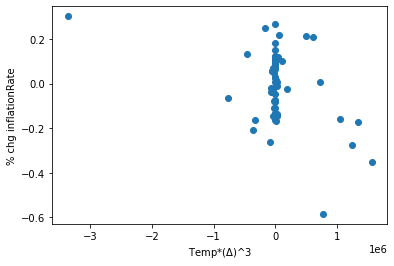

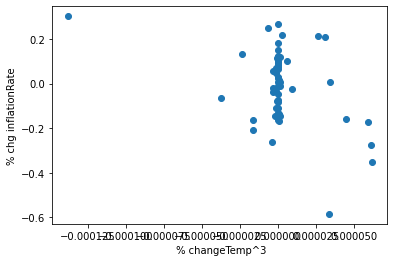

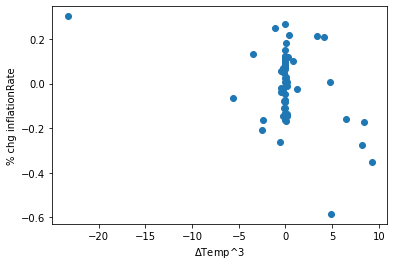

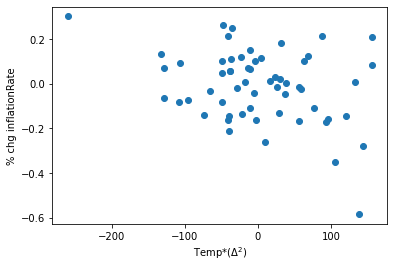

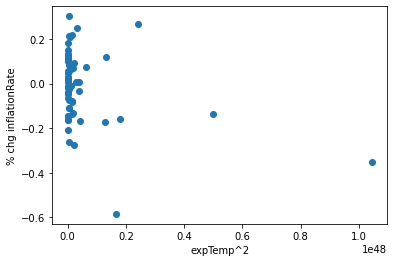

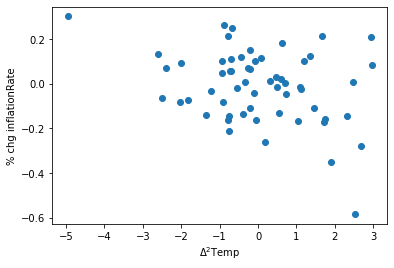

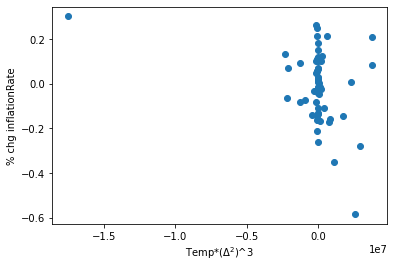

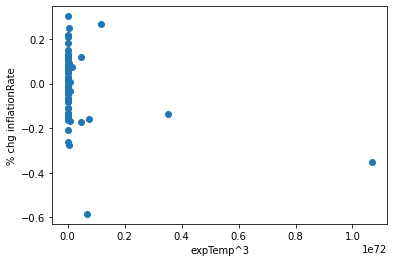

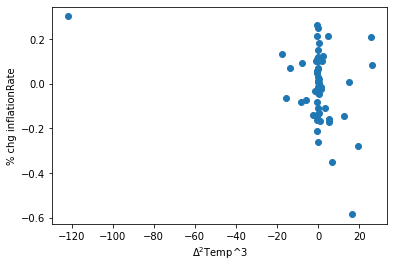

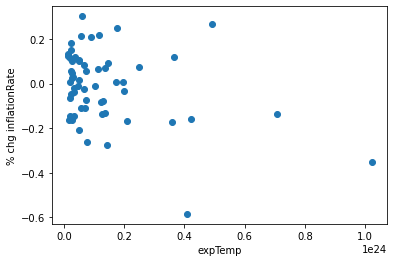

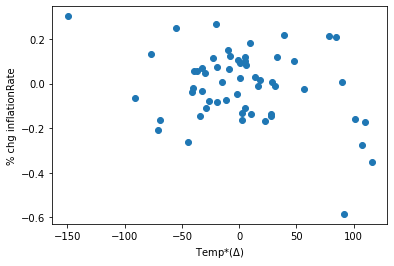

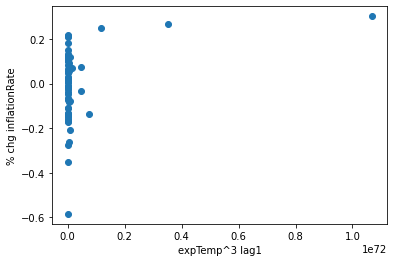

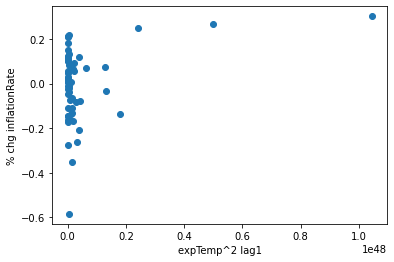

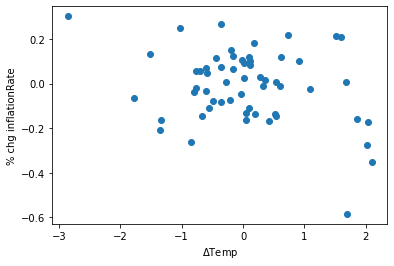

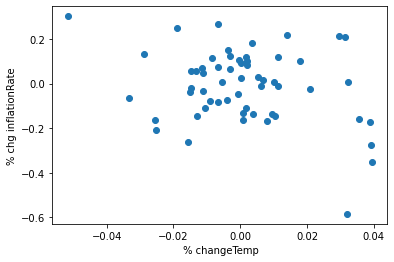

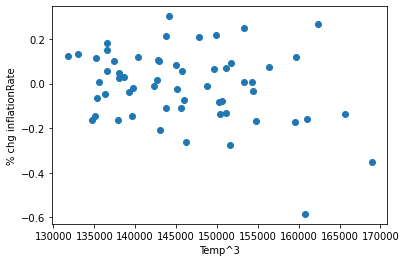

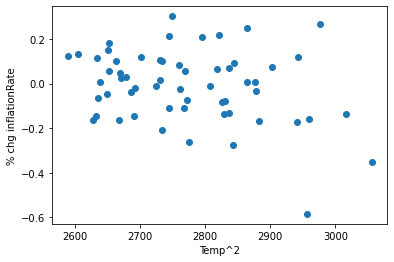

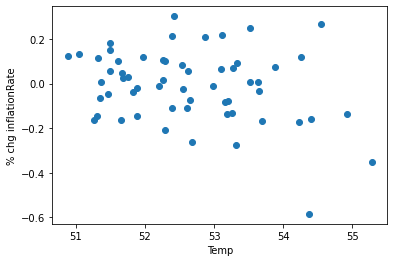

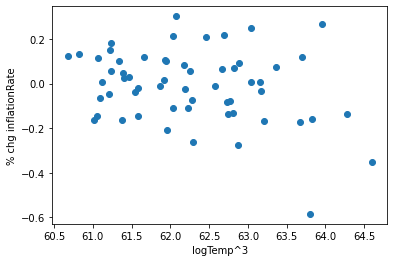

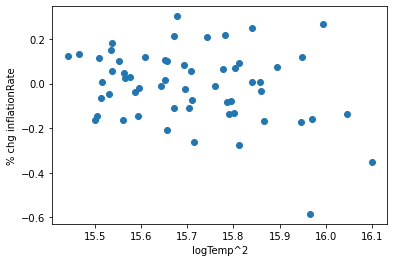

In [9]:
for i in range(20):
    plt.scatter(ind[var_list[i]]['1962':'2020'],dep['% chg inflationRate']['1962':'2020'])
    plt.xlabel(var_list[i])
    plt.ylabel('% chg inflationRate')
    plt.show()

### Inflation Rate on Precipitation

In [10]:
'''
Regress % change in inflationRate on all transformations of precipitation and display top 5 (one variable at a time)
'''
# Yearly Data
ind = build_independent_df('Precipitation', yearly=True)
summary = single_regression(dep,ind)
summary = summary.sort_values(by=['R_squared', 'p_value'], ascending=False)

display(summary.head())
#columnNames = list(summary.head().index)
columnNames = list(summary.index)
var_list = [i.split('_')[1] for i in columnNames]
print('Top variable:', var_list)

,R_squared,beta,p_value,RMSE
% chg inflationRate_Precipitation*($\Delta^2)$^2 lag1,0.076,0.0454,0.0362,0.1542
% chg inflationRate_$\Delta^2$Precipitation^2 lag1,0.0724,0.271,0.0411,0.1545
% chg inflationRate_expPrecipitation^3 lag1,0.0372,-0.0,0.1469,0.1574
% chg inflationRate_ % changePrecipitation^2 lag1,0.0341,3.5242,0.1654,0.1576
% chg inflationRate_expPrecipitation^2 lag1,0.0333,-0.0004,0.1704,0.1577


Top variable: ['Precipitation*($\\Delta^2)$^2 lag1', '$\\Delta^2$Precipitation^2 lag1', 'expPrecipitation^3 lag1', ' % changePrecipitation^2 lag1', 'expPrecipitation^2 lag1', ' % changePrecipitation^2 lag2', '$\\Delta$Precipitation^2 lag1', 'expPrecipitation lag1', 'Precipitation*($\\Delta)$^2 lag1', 'Precipitation^3 lag1', 'logPrecipitation^3 lag1', 'Precipitation^2 lag1', 'Precipitation lag1', 'logPrecipitation^2 lag1', 'Precipitation*($\\Delta)$^2 lag2', 'logPrecipitation lag1', '$\\Delta^2$Precipitation^2', 'Precipitation*($\\Delta^2)$^2', '$\\Delta$Precipitation^2 lag2', 'expPrecipitation^2 lag2', 'expPrecipitation^3 lag2', 'expPrecipitation lag2', 'Precipitation^3 lag2', 'logPrecipitation^3 lag2', 'Precipitation^2 lag2', 'Precipitation lag2', 'logPrecipitation^2 lag2', 'logPrecipitation lag2', 'Precipitation*($\\Delta)$^3 lag2', 'Precipitation*($\\Delta^2)$^2 lag2', '$\\Delta^2$Precipitation^2 lag2', 'expPrecipitation^3', 'expPrecipitation^2', 'expPrecipitation', 'Precipitation^3

In [11]:
'''
Get the correlation among variables
'''
tempdf = ind[var_list]
corrdf = dep.join(tempdf)
corrdf.corr()

,% chg inflationRate,Precipitation*($\Delta^2)$^2 lag1,$\Delta^2$Precipitation^2 lag1,expPrecipitation^3 lag1,% changePrecipitation^2 lag1,expPrecipitation^2 lag1,% changePrecipitation^2 lag2,$\Delta$Precipitation^2 lag1,expPrecipitation lag1,Precipitation*($\Delta)$^2 lag1,...,$\Delta^2$Precipitation lag1,$\Delta$Precipitation lag2,$\Delta^2$Precipitation^3 lag1,$\Delta$Precipitation lag1,Precipitation*($\Delta)$ lag1,Precipitation*($\Delta^2)$ lag1,Precipitation*($\Delta^2)$^3 lag1,% changePrecipitation lag1,Precipitation*($\Delta)$^2,$\Delta$Precipitation^2
% chg inflationRate,1.0000,0.2757,0.2691,-0.1929,0.1846,-0.1825,0.1808,0.1764,-0.1711,0.1692,...,-0.0282,0.0253,-0.0227,-0.0210,-0.0159,-0.0160,-0.0144,-0.0076,0.0085,0.0114
Precipitation*($\Delta^2)$^2 lag1,0.2757,1.0000,0.9888,-0.1630,0.6776,-0.1569,0.6144,0.6334,-0.1474,0.6346,...,0.1024,-0.2231,0.2610,-0.0550,-0.0520,0.1186,0.3377,0.0099,0.0541,0.0826
$\Delta^2$Precipitation^2 lag1,0.2691,0.9888,1.0000,-0.2299,0.7284,-0.2292,0.5895,0.6983,-0.2246,0.6758,...,0.0346,-0.1887,0.1781,-0.1324,-0.1256,0.0537,0.2652,-0.0661,0.0344,0.0548
expPrecipitation^3 lag1,-0.1929,-0.1630,-0.2299,1.0000,-0.1530,0.9951,-0.1225,-0.1492,0.9784,-0.0094,...,0.2010,0.1969,0.1122,0.5301,0.5475,0.2011,0.0972,0.5065,0.2696,0.2645
% changePrecipitation^2 lag1,0.1846,0.6776,0.7284,-0.1530,1.0000,-0.1817,0.1363,0.9664,-0.2132,0.9571,...,-0.0296,-0.0758,-0.0516,-0.1251,-0.0852,0.0038,0.0490,-0.0635,0.0317,0.0390
expPrecipitation^2 lag1,-0.1825,-0.1569,-0.2292,0.9951,-0.1817,1.0000,-0.1173,-0.1810,0.9940,-0.0359,...,0.2182,0.1957,0.1327,0.5573,0.5698,0.2168,0.1138,0.5358,0.2357,0.2332
% changePrecipitation^2 lag2,0.1808,0.6144,0.5895,-0.1225,0.1363,-0.1173,1.0000,0.0633,-0.1086,0.0584,...,0.1342,-0.1195,0.3890,0.1016,0.0899,0.1230,0.4030,0.1249,0.0372,0.0331
$\Delta$Precipitation^2 lag1,0.1764,0.6334,0.6983,-0.1492,0.9664,-0.1810,0.0633,1.0000,-0.2160,0.9743,...,-0.2162,0.0587,-0.2639,-0.2984,-0.2551,-0.1789,-0.1577,-0.2425,0.0551,0.0600
expPrecipitation lag1,-0.1711,-0.1474,-0.2246,0.9784,-0.2132,0.9940,-0.1086,-0.2160,1.0000,-0.0662,...,0.2341,0.1937,0.1547,0.5816,0.5882,0.2308,0.1313,0.5628,0.1924,0.1924
Precipitation*($\Delta)$^2 lag1,0.1692,0.6346,0.6758,-0.0094,0.9571,-0.0359,0.0584,0.9743,-0.0662,1.0000,...,-0.1286,0.0533,-0.1821,-0.1589,-0.1160,-0.0928,-0.0899,-0.1025,0.0421,0.0520


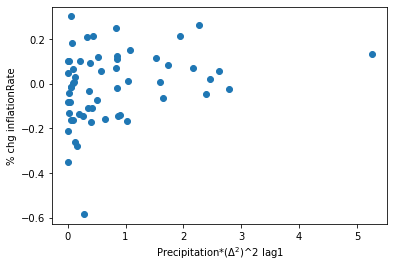

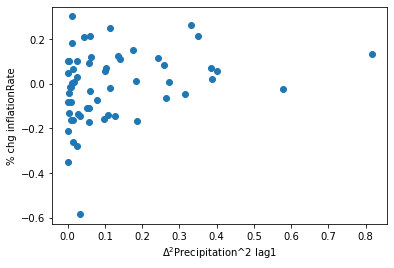

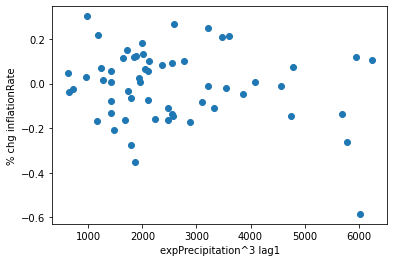

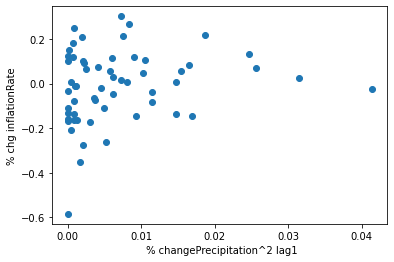

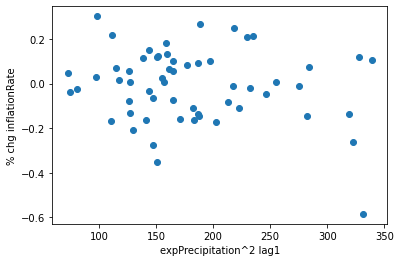

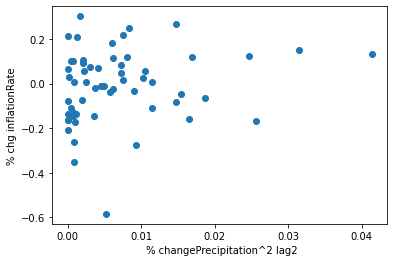

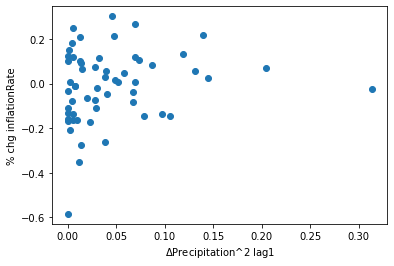

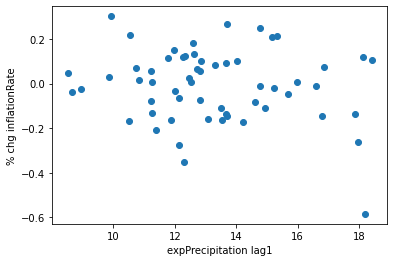

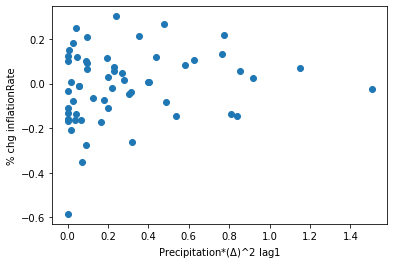

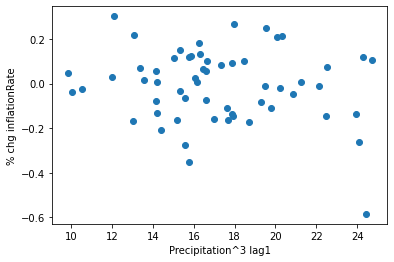

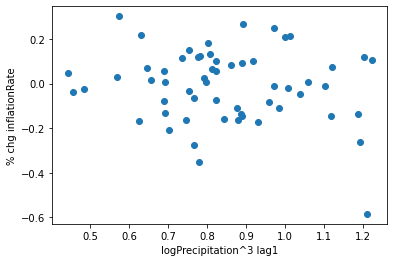

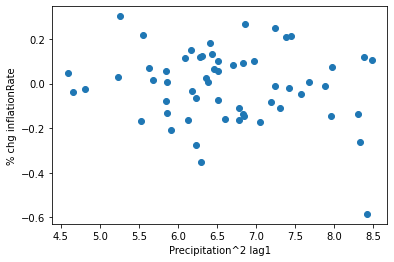

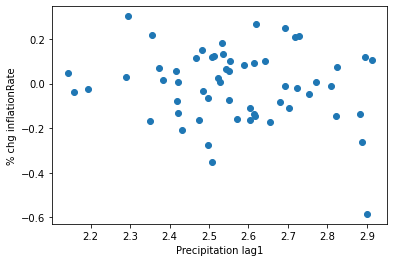

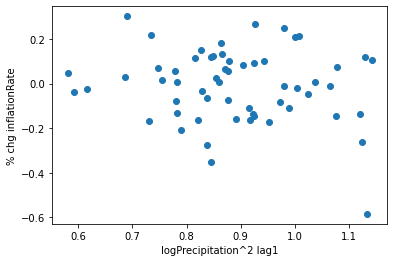

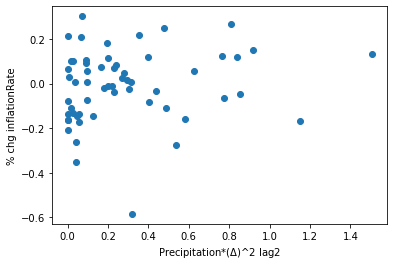

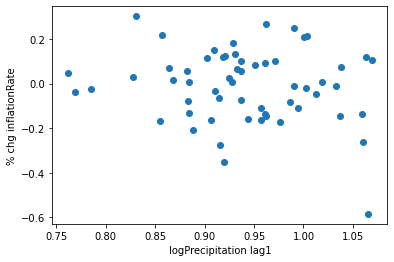

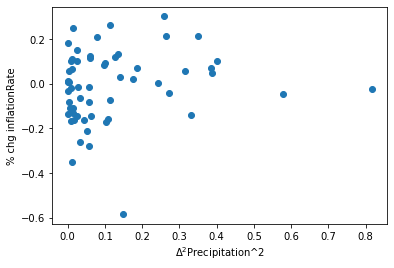

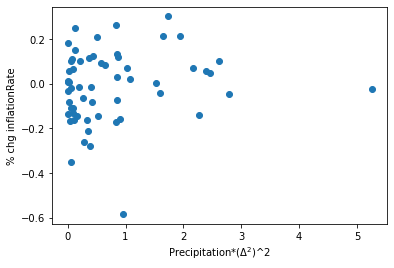

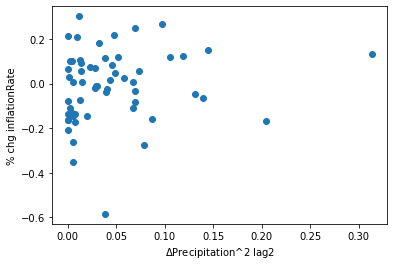

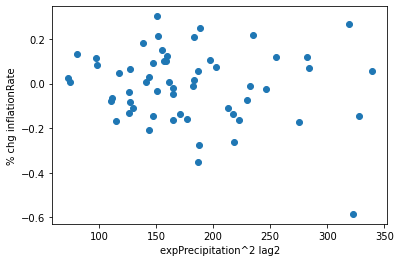

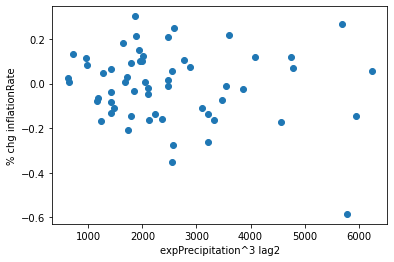

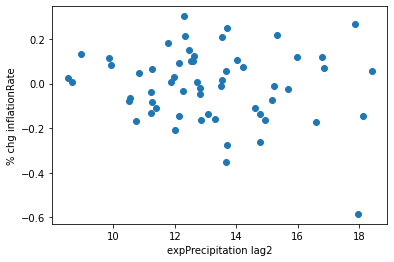

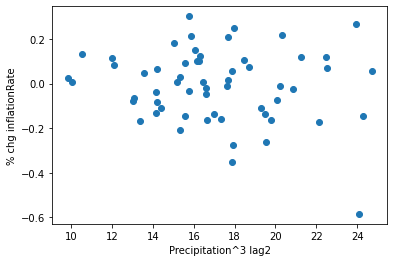

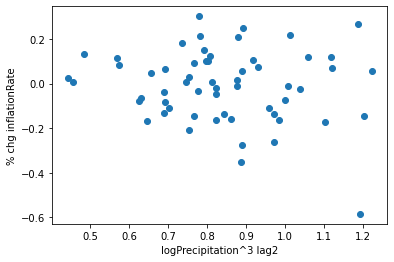

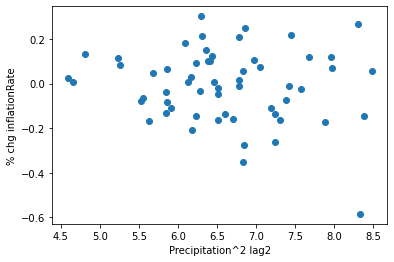

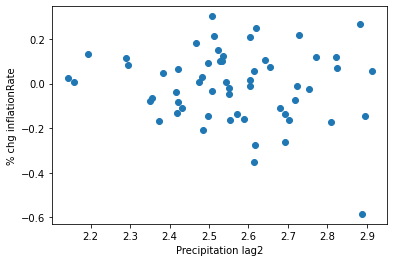

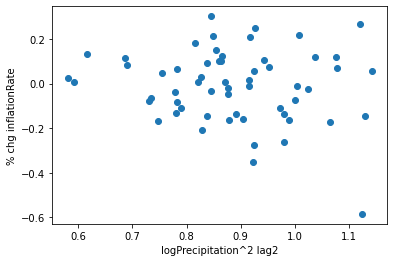

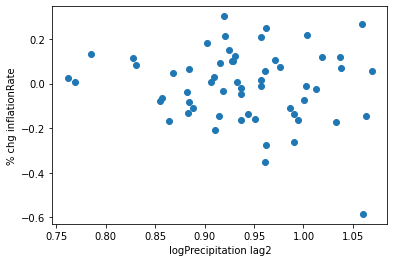

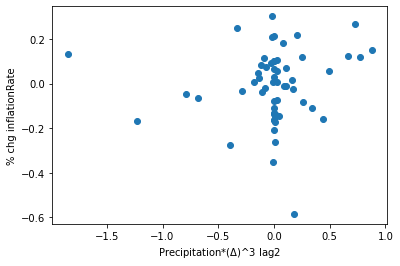

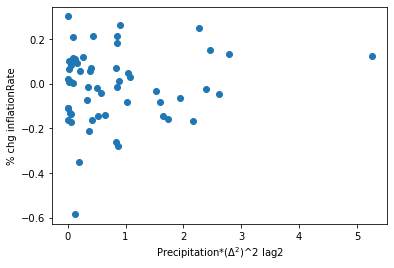

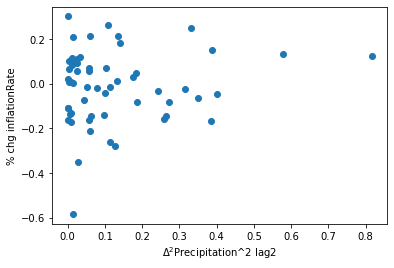

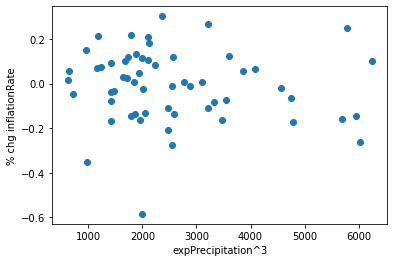

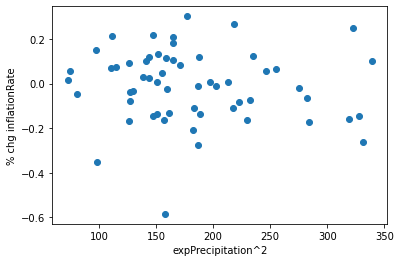

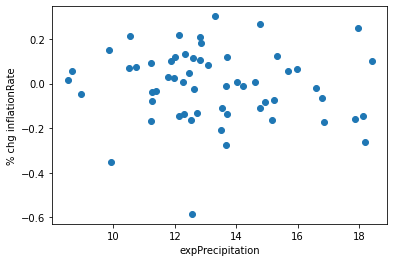

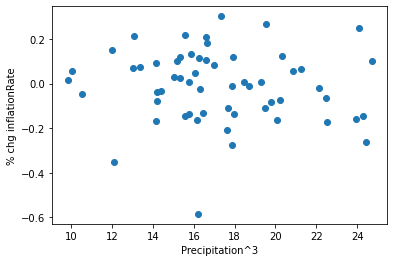

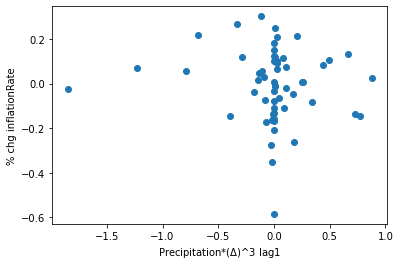

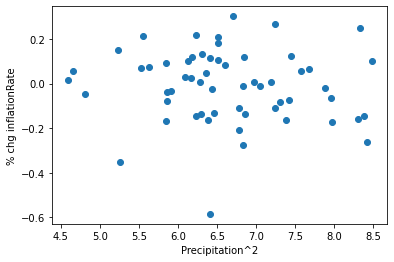

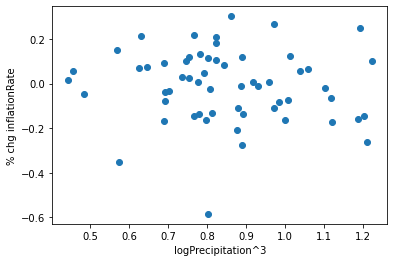

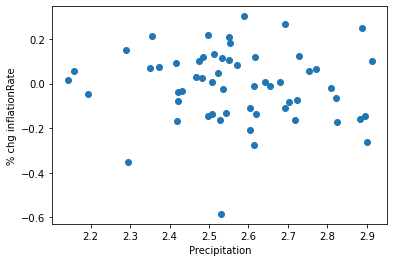

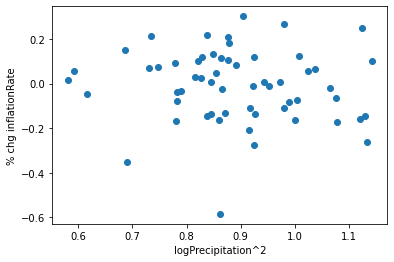

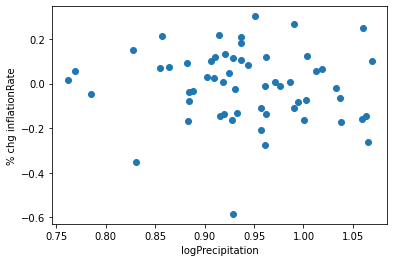

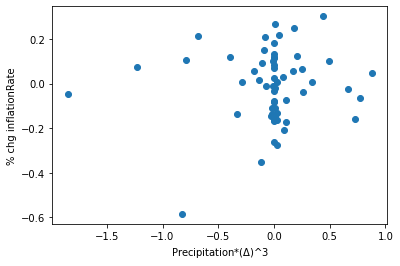

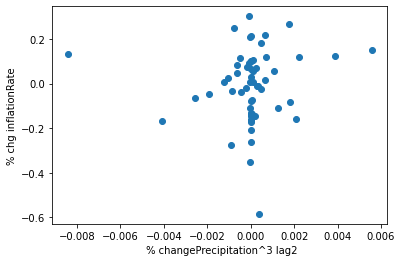

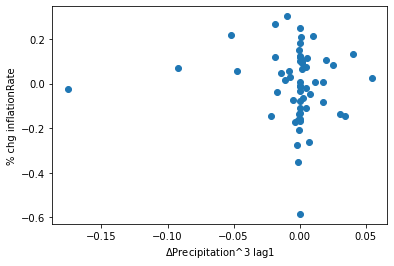

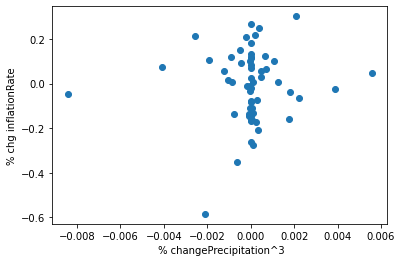

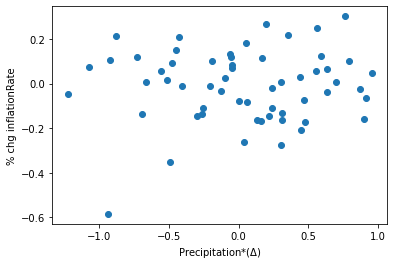

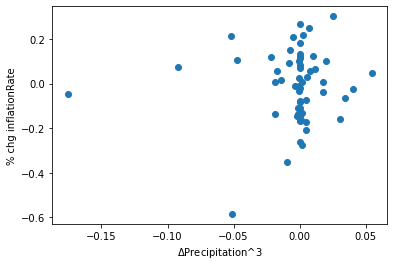

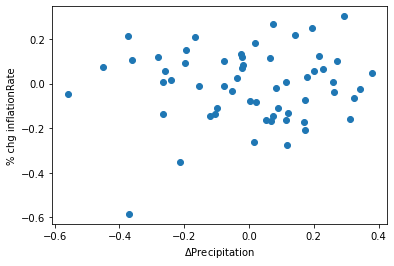

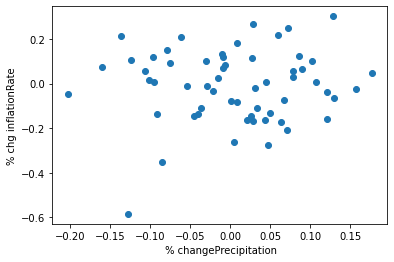

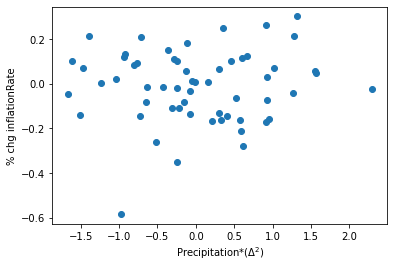

In [13]:
for i in range(50):
    plt.scatter(ind[var_list[i]]['1962':'2020'],dep['% chg inflationRate']['1962':'2020'])
    plt.xlabel(var_list[i])
    plt.ylabel('% chg inflationRate')
    plt.show()

### Inflation Rate on Sea level

In [13]:
'''
Sea Level Data requires some extra data-formatting to be consistent with other functions
'''

# Yearly Data
df = pd.read_excel('Sea Level.xls').iloc[:, 0:2].set_index('Date')
df.columns = ['Value']
variable = 'Sea Level'
df = df.rename(columns={"Value": 'Sea Level'})

df_sqr = df**2
col_names = df.columns
for name in col_names:
    df_sqr = df_sqr.rename(columns={name:name+r'^2'})

df = pd.concat([df, df_sqr], axis = 1)

df_lag1 = df.shift()
col_names = df.columns
for name in col_names:
    df_lag1 = df_lag1.rename(columns={name:name+' lag1'})

df_lag2 = df.shift(2)
col_names = df.columns
for name in col_names:
    df_lag2 = df_lag2.rename(columns={name:name+' lag2'})

df = pd.concat([df,df_lag1,df_lag2], axis = 1)
#df['log Sea Level'] = np.log(df['Sea Level'])
df['exp Sea Level'] = np.exp(df['Sea Level'])

df.index = df.index.to_period('Y')

In [14]:
# Yearly Data
ind = df['1962':'2019']
dep = build_dependent_df('inflationRate', yearly=True)['1962':'2019']
summary = single_regression(dep,ind)
summary = summary.sort_values(by=['R_squared', 'p_value'], ascending=False)

display(summary.head())
columnNames = list(summary.head().index)
var_list = [i.split('_')[1] for i in columnNames]
print('Top variable:', var_list)

,R_squared,beta,p_value,RMSE
% chg inflationRate_Sea Level lag2,0.0463,-0.1648,0.1081,0.1391
% chg inflationRate_Sea Level lag1,0.042,0.1581,0.126,0.1394
% chg inflationRate_Sea Level^2 lag1,0.0163,0.3173,0.3441,0.1413
% chg inflationRate_Sea Level^2 lag2,0.0077,0.2179,0.517,0.1419
% chg inflationRate_Sea Level,0.0018,-0.033,0.7554,0.1423


Top variable: ['Sea Level lag2', 'Sea Level lag1', 'Sea Level^2 lag1', 'Sea Level^2 lag2', 'Sea Level']


In [15]:
'''
Get the correlation among variables
'''

tempdf = ind[var_list]
corrdf = dep.join(tempdf)
corrdf.corr()

,% chg inflationRate,Sea Level lag2,Sea Level lag1,Sea Level^2 lag1,Sea Level^2 lag2,Sea Level
% chg inflationRate,1.0000,-0.2151,0.2051,0.1276,0.0876,-0.0422
Sea Level lag2,-0.2151,1.0000,-0.3201,-0.2187,0.4507,0.0551
Sea Level lag1,0.2051,-0.3201,1.0000,0.4508,-0.2433,-0.3205
Sea Level^2 lag1,0.1276,-0.2187,0.4508,1.0000,0.0500,-0.2443
Sea Level^2 lag2,0.0876,0.4507,-0.2433,0.0500,1.0000,-0.0827
Sea Level,-0.0422,0.0551,-0.3205,-0.2443,-0.0827,1.0000


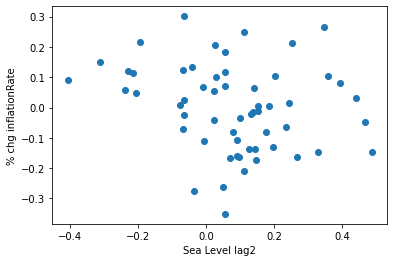

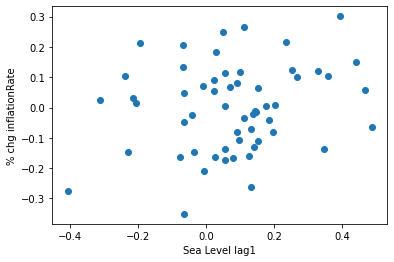

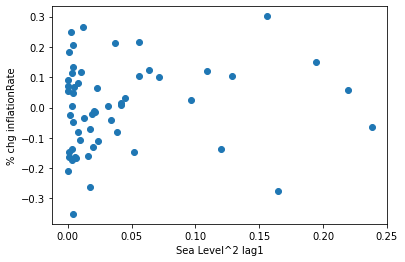

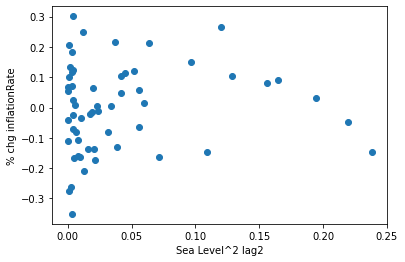

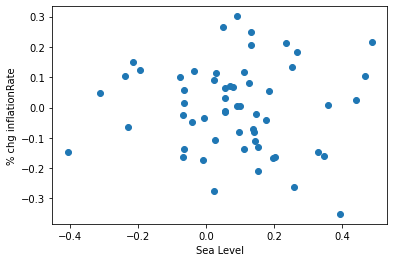

In [16]:
for i in range(5):
    plt.scatter(ind[var_list[i]]['1962':'2020'],dep['% chg inflationRate']['1962':'2020'])
    plt.xlabel(var_list[i])
    plt.ylabel('% chg inflationRate')
    plt.show()

## Multi - Regression Model

In [15]:
sea = ind['Sea Level lag2']
dep = build_dependent_df('inflationRate', yearly=True)
ind = build_independent_df('Precipitation', yearly=True)
Precip = pd.DataFrame(ind[['Precipitation*($\\Delta^2)$^2 lag1',]])
ind = build_independent_df('Temp', yearly=True)
Temp = ind['Temp*($\\Delta)$^3']
data = pd.concat([dep, Temp ,Precip,sea], axis = 1).dropna().reset_index()
data.columns = ['Date', 'inflationRate_pct_change', '(Temp*Diff)^3', '(Preci*SecondDiff)^2 lag1', 'SeaLevelChange lag2']


In [16]:
'''
Run the multi regression on each subsets of the set, print out the statistics values including beta values,
R_Squared, Adjusted R_Squared, and AIC score, and plot the scatter plot of actual value on predicted value.
'''

def multi_regression(independent, dependent): 
    summary = pd.DataFrame()
    independent_w_constant = sm.add_constant(independent)
    res = sm.OLS(dependent, independent_w_constant, missing='drop').fit()
    r_squared = round(res.rsquared, 4)
    adj_r_squared = round(res.rsquared_adj, 4)
    summary = pd.DataFrame(res.params[1:], columns = dependent.columns)
    summary.loc['R_squared'] = r_squared
    summary.loc['adj_R_suqared'] = adj_r_squared
    summary.loc['AIC'] = res.aic
    cols = ['VIF_'] + independent.columns
    
    
    if len(independent.columns) > 1:
        for i in range(len(independent.columns)):
            summary.loc['VIF_' + independent.columns[i]] = variance_inflation_factor(independent.values, i)

        display(independent.corr())
        
    plt.scatter(dependent, res.predict(independent_w_constant))
    plt.xlabel('Prediction')
    plt.ylabel('Actual Value')
    plt.show()
    
    
    return summary.round(4)

inflationRate_pct_change on ['(Temp*Diff)^3']


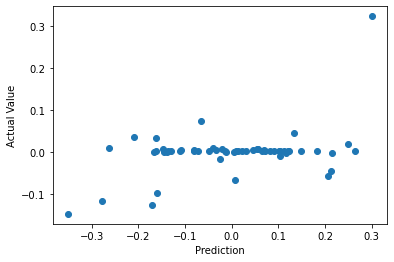

,inflationRate_pct_change
(Temp*Diff)^3,-0.0000
R_squared,0.1615
adj_R_suqared,0.1463
AIC,-66.4433



inflationRate_pct_change on ['(Preci*SecondDiff)^2 lag1']


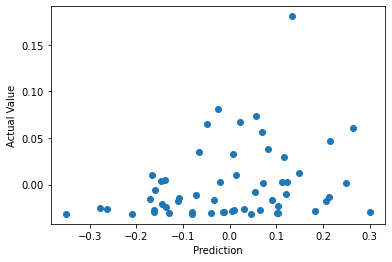

,inflationRate_pct_change
(Preci*SecondDiff)^2 lag1,0.0404
R_squared,0.0770
adj_R_suqared,0.0602
AIC,-60.9702



inflationRate_pct_change on ['SeaLevelChange lag2']


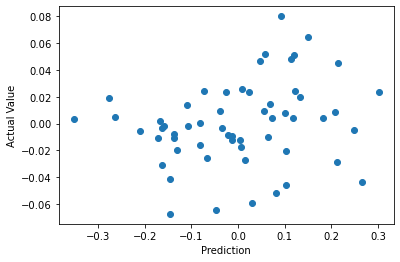

,inflationRate_pct_change
SeaLevelChange lag2,-0.1648
R_squared,0.0463
adj_R_suqared,0.0289
AIC,-59.1010



inflationRate_pct_change on ['(Temp*Diff)^3', '(Preci*SecondDiff)^2 lag1']


,(Temp*Diff)^3,(Preci*SecondDiff)^2 lag1
(Temp*Diff)^3,1.0000,-0.0582
(Preci*SecondDiff)^2 lag1,-0.0582,1.0000


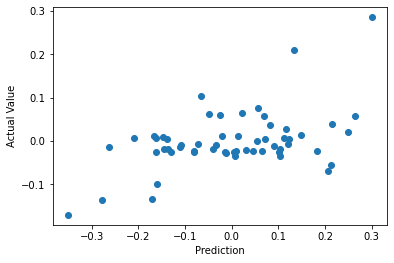

,inflationRate_pct_change
(Temp*Diff)^3,-0.0000
(Preci*SecondDiff)^2 lag1,0.0371
R_squared,0.2263
adj_R_suqared,0.1977
AIC,-69.0278
VIF_(Temp*Diff)^3,1.0003
VIF_(Preci*SecondDiff)^2 lag1,1.0003



inflationRate_pct_change on ['(Temp*Diff)^3', 'SeaLevelChange lag2']


,(Temp*Diff)^3,SeaLevelChange lag2
(Temp*Diff)^3,1.0000,0.0727
SeaLevelChange lag2,0.0727,1.0000


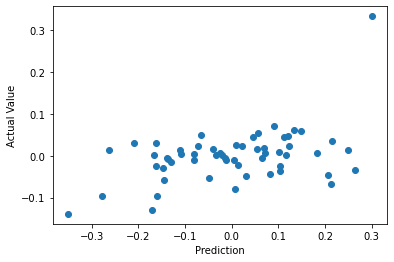

,inflationRate_pct_change
(Temp*Diff)^3,-0.0000
SeaLevelChange lag2,-0.1432
R_squared,0.1962
adj_R_suqared,0.1665
AIC,-66.8539
VIF_(Temp*Diff)^3,1.0072
VIF_SeaLevelChange lag2,1.0072



inflationRate_pct_change on ['(Preci*SecondDiff)^2 lag1', 'SeaLevelChange lag2']


,(Preci*SecondDiff)^2 lag1,SeaLevelChange lag2
(Preci*SecondDiff)^2 lag1,1.0000,-0.0934
SeaLevelChange lag2,-0.0934,1.0000


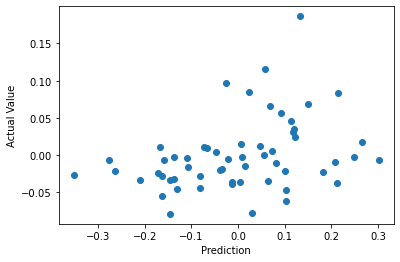

,inflationRate_pct_change
(Preci*SecondDiff)^2 lag1,0.0378
SeaLevelChange lag2,-0.1462
R_squared,0.1131
adj_R_suqared,0.0803
AIC,-61.2435
VIF_(Preci*SecondDiff)^2 lag1,1.0334
VIF_SeaLevelChange lag2,1.0334



inflationRate_pct_change on ['(Temp*Diff)^3', '(Preci*SecondDiff)^2 lag1', 'SeaLevelChange lag2']


,(Temp*Diff)^3,(Preci*SecondDiff)^2 lag1,SeaLevelChange lag2
(Temp*Diff)^3,1.0000,-0.0582,0.0727
(Preci*SecondDiff)^2 lag1,-0.0582,1.0000,-0.0934
SeaLevelChange lag2,0.0727,-0.0934,1.0000


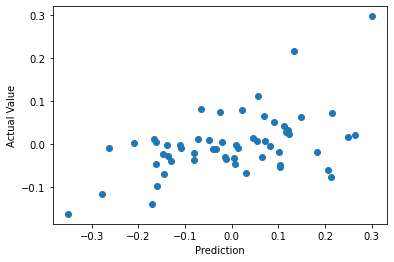

,inflationRate_pct_change
(Temp*Diff)^3,-0.0000
(Preci*SecondDiff)^2 lag1,0.0349
SeaLevelChange lag2,-0.1267
R_squared,0.2533
adj_R_suqared,0.2110
AIC,-69.0494
VIF_(Temp*Diff)^3,1.0083
VIF_(Preci*SecondDiff)^2 lag1,1.0346
VIF_SeaLevelChange lag2,1.0417


In [17]:
ind_list = ['(Temp*Diff)^3', '(Preci*SecondDiff)^2 lag1', 'SeaLevelChange lag2']
for L in range(1, len(ind_list)+1):
    for subset in itertools.combinations(ind_list, L):
        ind_subset = list(subset)
        print('inflationRate_pct_change on', ind_subset)
        display(multi_regression(data.loc[:, ind_subset], data.loc[:, ['inflationRate_pct_change']]))
        print()
